# 1. Evaluation of Hyperparameters

## 1.1 How many hyperparameters are chosen the same?

We run experiments for both stratified and unstratified cross-validation, while the hyperparameter grid stays the same. We have 200 iterations, i.e. 200 different hyperparameter combinations (same options for statified and unstratified). Now we want to evaluate how many times the two methods chose the same hyperparameters.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
# remove waringns
import warnings
warnings.filterwarnings("ignore")


from utils_evaluation import flatten_data

In [2]:
def read_data(json_path):
    json_files = os.listdir(json_path)
    data = []
    for file in json_files:
        with open(json_path + file) as f:
            data_new = json.load(f)
            data = data + data_new
    # flatten dictionary and convert to dataframe
    data_all_flatten, keys_dic = flatten_data(data)
    data = pd.DataFrame(data_all_flatten)
    return data


In [3]:
json_path ="../results/rf/"
json_path_xgb = "../results/xgb/"

data_rf = read_data(json_path)
data_xgb = read_data(json_path_xgb)

print('\nData Loading from json file:')
print('Loaded Random Forest data from json file: shape', data_rf.shape)
print('Loaded XGBoost data from json file: shape', data_xgb.shape)


Data Loading from json file:
Loaded Random Forest data from json file: shape (4800, 75)
Loaded XGBoost data from json file: shape (4800, 87)


In [4]:
data_rf.head()

,model_info_model,model_info_n_train,model_info_n_test,model_info_n_features,model_info_noise,model_info_transformation,model_info_group_size,model_info_n_folds,model_info_n_iter,model_info_n_repetitions,...,cv_folds_descriptives_unstratified_intersection_area,cv_folds_descriptives_stratified_ks_statistic,cv_folds_descriptives_stratified_p_value,cv_folds_descriptives_stratified_intersection_area,unstratified_best_params_min_samples_split,unstratified_best_params_min_samples_leaf,unstratified_best_params_max_features,stratified_best_params_min_samples_split,stratified_best_params_min_samples_leaf,stratified_best_params_max_features
0,rf,200,100000,8,0,identity,5,5,200,30,...,0.877017,0.025,1.0,0.957862,2,1,8,2,1,6
1,rf,200,100000,8,0,identity,5,5,200,30,...,0.874369,0.025,1.0,0.947189,4,1,7,5,1,6
2,rf,200,100000,8,0,identity,5,5,200,30,...,0.897163,0.025,1.0,0.959497,2,1,7,2,1,7
3,rf,200,100000,8,0,identity,5,5,200,30,...,0.886524,0.025,1.0,0.955489,2,1,6,2,1,5
4,rf,200,100000,8,0,identity,5,5,200,30,...,0.881115,0.025,1.0,0.964351,2,1,7,4,1,5


In [5]:
models = ['rf', 'xgb']
for model in models:
    if model == 'rf':
        data = data_rf
    else:
        data = data_xgb
    print(f"Percentage of different hyperparameter combinations of {model}: ", round(data.hyperparameters_same.value_counts()[0] / data.shape[0], 2))

    print(data.hyperparameters_same.value_counts())
    print("\n")

Percentage of different hyperparameter combinations of rf:  0.66
hyperparameters_same
False    3155
True     1645
Name: count, dtype: int64


Percentage of different hyperparameter combinations of xgb:  0.77
hyperparameters_same
False    3711
True     1089
Name: count, dtype: int64




In [6]:
df_plot1 = pd.concat([data_rf[['model_info_model', 'hyperparameters_same']], data_xgb[['model_info_model', 'hyperparameters_same']]], axis=0)

In [7]:

# Group by model_info_model and hyperparameters_same, then count occurrences
grouped_data = df_plot1.groupby(['model_info_model', 'hyperparameters_same']).size().unstack(fill_value=0)
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
grouped_data


hyperparameters_same,False,True
model_info_model,,
rf,65.729167,34.270833
xgb,77.312500,22.687500


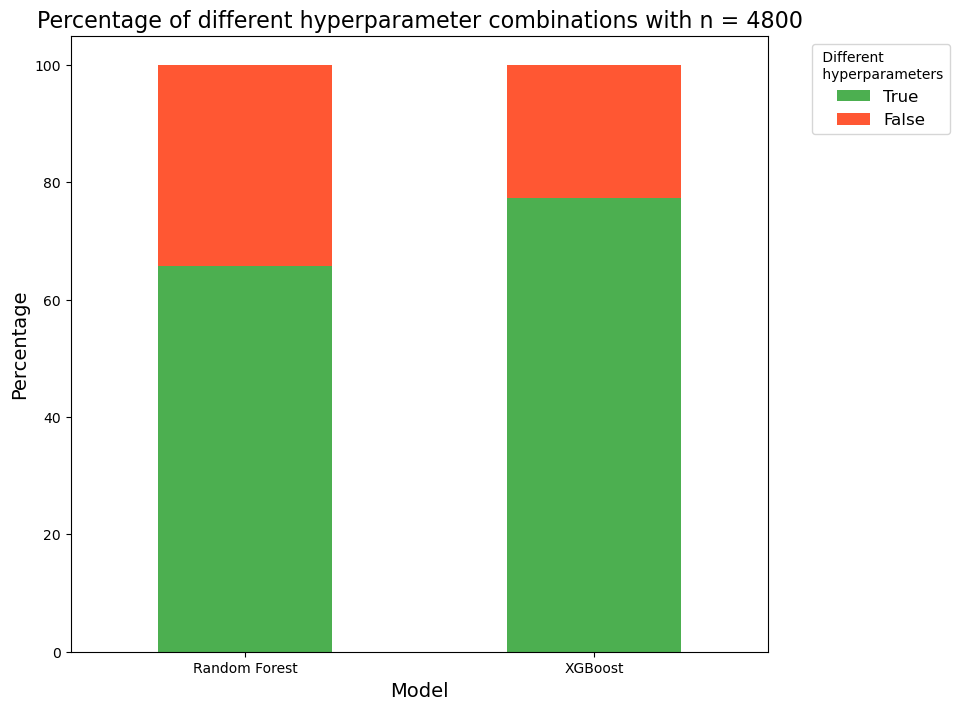

In [8]:
# Plot the stacked bar chart
grouped_data.plot(kind='bar', stacked=True, figsize=(9, 8), color=['#4CAF50', '#FF5733'])
plt.xlabel('Model', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Percentage of different hyperparameter combinations with n = 4800', fontsize=16)
plt.legend(title=' Different \n hyperparameters', labels=['True', 'False'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks([0, 1], ['Random Forest', 'XGBoost'], rotation=0)
plt.show()

## 1.2 Boxplots of best hyperparameters

We saw that 66% and 77% of Random Forest and XGBoost respectively have different best hyperparameters for stratified vs. unstratified. Now we want to see what hyperparameters were chosen in the end (per model) by using boxplots.

### 1.2.1 Random Forest

In [9]:
data_rf.columns

Index(['model_info_model', 'model_info_n_train', 'model_info_n_test',
       'model_info_n_features', 'model_info_noise',
       'model_info_transformation', 'model_info_group_size',
       'model_info_n_folds', 'model_info_n_iter', 'model_info_n_repetitions',
       'model_info_scoring', 'model_info_n_jobs', 'model_info_json_file',
       'repetition', 'random_state', 'hyperparameters_same',
       'unstratified_results_train r2', 'unstratified_results_test r2',
       'unstratified_results_train mse', 'unstratified_results_test mse',
       'unstratified_results_train mae', 'unstratified_results_test mae',
       'stratified_results_train r2', 'stratified_results_test r2',
       'stratified_results_train mse', 'stratified_results_test mse',
       'stratified_results_train mae', 'stratified_results_test mae',
       'cv_unstratified_iterations_mean_fit_time',
       'cv_unstratified_iterations_std_fit_time',
       'cv_unstratified_iterations_mean_score_time',
       'cv_unstratifie

In [10]:
data_plot2 = data_rf[['unstratified_best_params_min_samples_split',
                      'stratified_best_params_min_samples_split',
                      'unstratified_best_params_min_samples_leaf',
                      'stratified_best_params_min_samples_leaf',
                      'unstratified_best_params_max_features',
                      'stratified_best_params_max_features']]
data_plot2.shape

(4800, 6)

In [11]:
def plot_hyperparams(data, hyperparam):
    # Melt the dataframe to make it suitable for boxplot
    melted_df = pd.melt(data[[f'unstratified_best_params_{hyperparam}', f'stratified_best_params_{hyperparam}']], var_name='Hyperparameter', value_name='Value')
    data_plot = melted_df.groupby(['Hyperparameter', 'Value']).value_counts().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="count", hue="Hyperparameter", data=data_plot)

    # Add labels and title
    plt.xlabel("Value")
    plt.ylabel("Hyperparameter")
    plt.title("Grouped barplot of best chosen hyperparameter {}".format(hyperparam))
    plt.show()

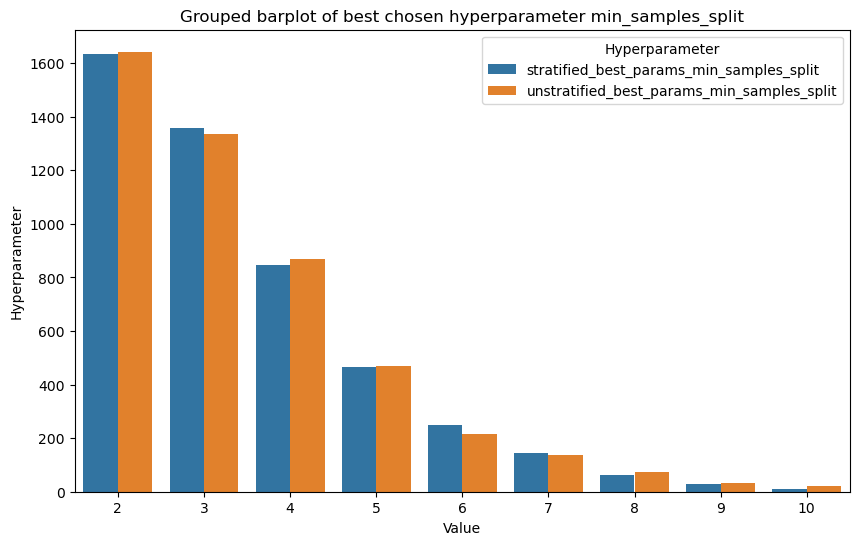

In [12]:
plot_hyperparams(data_rf, 'min_samples_split')

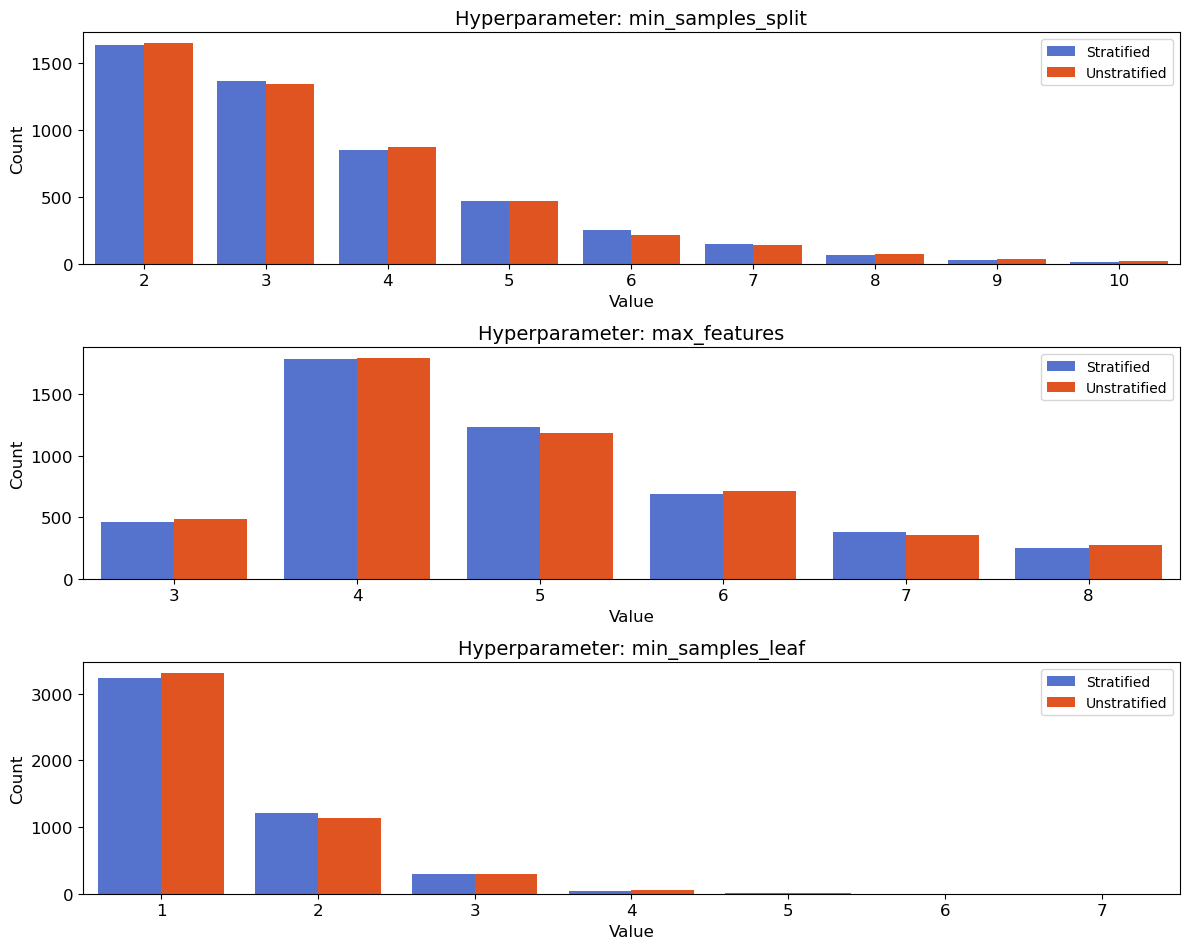

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hyperparams(data, hyperparams, nrows, ncols, histo = False):
    # Create a grid for subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))
    #fig.suptitle("Grouped barplots of best chosen hyperparameters", fontsize=20)

    # Flatten the array of subplots
    axes = axes.flatten()

    for i, hyperparam in enumerate(hyperparams):
        # Melt the dataframe to make it suitable for boxplot
        melted_df = pd.melt(data[[f'unstratified_best_params_{hyperparam}', f'stratified_best_params_{hyperparam}']], var_name='Hyperparameter', value_name='Value')
        data_plot = melted_df.groupby(['Hyperparameter', 'Value']).value_counts().reset_index()

        # Select the current subplot
        ax = axes[i]
        if histo:
            # Create a grouped histogram for the current hyperparameter
            #sns.displot(data_plot, x="Value", hue="Hyperparameter", #multiple="stack", 
            #             ax=ax, bins=30, kde=True, stat= "density")
            plt.hist(data[f'unstratified_best_params_{hyperparam}'], bins=30, alpha=0.5, label="Unstratified", ax=ax)
            plt.hist(data[f'stratified_best_params_{hyperparam}'], bins=30, alpha=0.5, label="Stratified", ax=ax)
            # Add labels and title to the subplot
            ax.set_xlabel(hyperparam)
            ax.set_ylabel("Count")
            ax.set_title(f"Hyperparameter: ${hyperparam}$", fontsize = 16)
        else:
            # Create a grouped barplot for the current hyperparameter
            sns.barplot(x="Value", y="count", hue="Hyperparameter", data=data_plot, ax=ax, palette={f'stratified_best_params_{hyperparam}': 'royalblue', f'unstratified_best_params_{hyperparam}': 'orangered'})
            #legend_elements = [Patch(facecolor)]
            # Add labels and title to the subplot

            ax.set_xlabel("Value", fontsize = 12)
            ax.set_ylabel("Count", fontsize = 12)
            x_tick_labels = ax.get_xticklabels()
            rounded_labels = [round(float(label.get_text()), 2) if '.' in label.get_text() else label.get_text() for label in x_tick_labels]
            ax.set_xticklabels(rounded_labels, fontsize=12)
            ax.tick_params(axis='y', labelsize=12)
            ax.set_title(f"Hyperparameter: {hyperparam}", fontsize=14)
            legend = ax.legend(loc='upper right') 

            for j, label in enumerate(legend.get_texts()):
                if label.get_text() == f'stratified_best_params_{hyperparam}':
                    label.set_text('Stratified')
                elif label.get_text() == f'unstratified_best_params_{hyperparam}':
                    label.set_text('Unstratified') 
            #ax.legend([f'stratified_best_params_{hyperparam}', f'unstratified_best_params_{hyperparam}'], labels=['Stratified', 'Unstratified'], markerscale = 3)

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
hyperparams_list = ['min_samples_split', 'max_features', 'min_samples_leaf']
plot_hyperparams(data_rf, hyperparams_list, nrows=3, ncols=1)


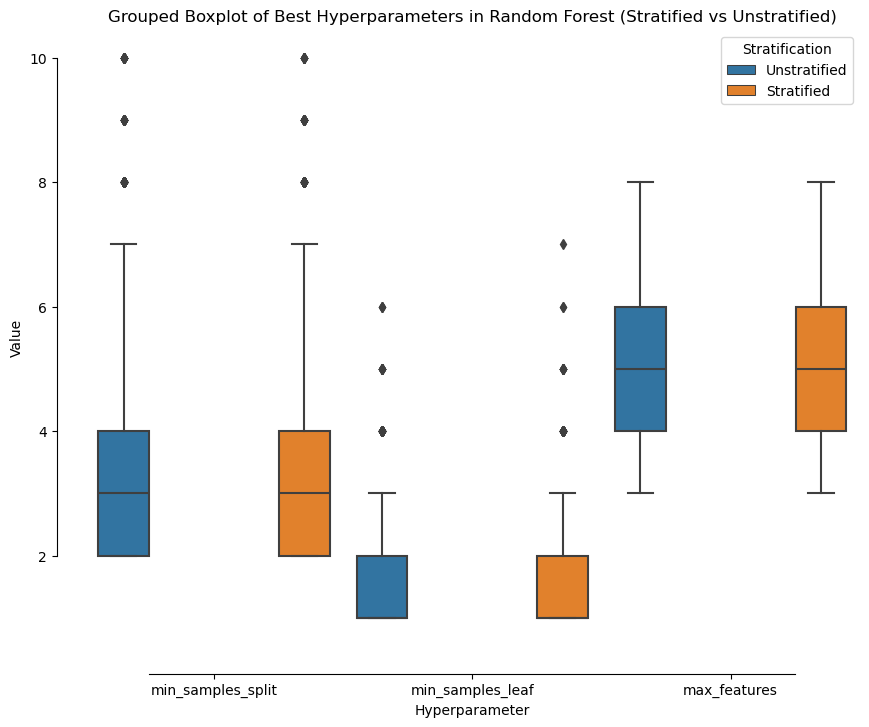

In [14]:
# Melt the dataframe to make it suitable for boxplot
melted_df = pd.melt(data_plot2, var_name='Hyperparameter', value_name='Value')


# Add a column indicating whether it's stratified or unstratified
melted_df['Stratification'] = ['Unstratified' if 'unstratified' in col else 'Stratified' for col in melted_df['Hyperparameter']]


# Create a nested boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x='Hyperparameter', y='Value', hue='Stratification',  data=melted_df)
sns.despine(offset=20, trim=True)
plt.title('Grouped Boxplot of Best Hyperparameters in Random Forest (Stratified vs Unstratified)')
plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.xticks([0.5, 2.5, 4.5], ['min_samples_split', 'min_samples_leaf', 'max_features'])
plt.show()

import seaborn as sns



### 1.2.2 XGBoost

In [15]:
data_xgb.columns

Index(['model_info_model', 'model_info_n_train', 'model_info_n_test',
       'model_info_n_features', 'model_info_noise',
       'model_info_transformation', 'model_info_group_size',
       'model_info_n_folds', 'model_info_n_iter', 'model_info_n_repetitions',
       'model_info_scoring', 'model_info_n_jobs', 'model_info_json_file',
       'repetition', 'random_state', 'hyperparameters_same',
       'unstratified_results_train r2', 'unstratified_results_test r2',
       'unstratified_results_train mse', 'unstratified_results_test mse',
       'unstratified_results_train mae', 'unstratified_results_test mae',
       'stratified_results_train r2', 'stratified_results_test r2',
       'stratified_results_train mse', 'stratified_results_test mse',
       'stratified_results_train mae', 'stratified_results_test mae',
       'cv_unstratified_iterations_mean_fit_time',
       'cv_unstratified_iterations_std_fit_time',
       'cv_unstratified_iterations_mean_score_time',
       'cv_unstratifie

In [16]:
df_plot3 = data_xgb[['unstratified_best_params_max_depth',
                     'stratified_best_params_max_depth',
                     'unstratified_best_params_min_child_weight',
                     'stratified_best_params_min_child_weight',
                     'unstratified_best_params_gamma',
                     'stratified_best_params_gamma',
                     'unstratified_best_params_subsample',
                     'stratified_best_params_subsample',
                     'unstratified_best_params_colsample_bytree',
                     'stratified_best_params_colsample_bytree',
                     'unstratified_best_params_learning_rate',
                     'stratified_best_params_learning_rate']]
df_plot3.shape

(4800, 12)

In [17]:
order = ['unstratified_best_params_max_depth',
                     'stratified_best_params_max_depth',
                     'unstratified_best_params_min_child_weight',
                     'stratified_best_params_min_child_weight',
                     'unstratified_best_params_gamma',
                     'stratified_best_params_gamma',
                     'unstratified_best_params_subsample',
                     'stratified_best_params_subsample',
                     'unstratified_best_params_colsample_bytree',
                     'stratified_best_params_colsample_bytree',
                     'unstratified_best_params_learning_rate',
                     'stratified_best_params_learning_rate']

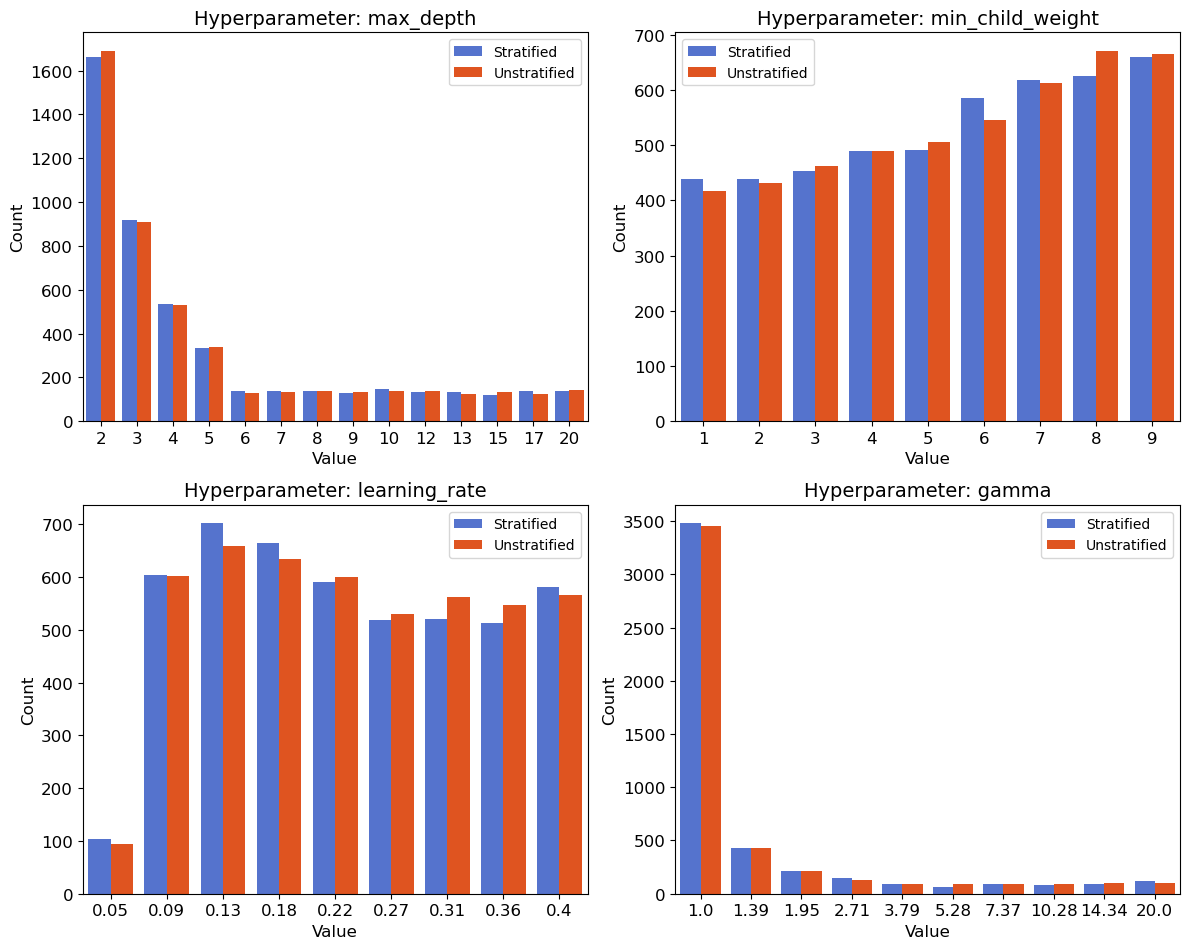

In [18]:
order = ['max_depth', 'min_child_weight', 'learning_rate', 'gamma']
plot_hyperparams(data_xgb, order, nrows=2, ncols=2)

In [19]:
def plot_hyperparams(data, hyperparams, nrows, ncols, histo = False):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))
    
    for i, hyperparam in enumerate(hyperparams):
        # Melt the dataframe to make it suitable for boxplot
        melted_df = pd.melt(data[[f'unstratified_best_params_{hyperparam}', f'stratified_best_params_{hyperparam}']],
                            var_name='Hyperparameter', value_name='Value')
        data_plot = melted_df.groupby(['Hyperparameter', 'Value']).value_counts().reset_index()

        # Select the current subplot
        if nrows == 1 or ncols == 1:
            ax = axes[i]
        else:
            ax = axes[i // ncols, i % ncols]

        if histo:
            # Create a grouped histogram for the current hyperparameter
            sns.histplot(data[f'unstratified_best_params_{hyperparam}'], ax=ax, bins=30, kde=True, stat="density", alpha = 0.7, label="Unstratified", color='orangered')
            sns.histplot(data[f'stratified_best_params_{hyperparam}'], ax=ax, bins=30, kde=True, stat="density", alpha = 0.7, label="Stratified", color = 'royalblue')
            
            # Add labels and title to the subplot
            ax.set_xlabel("Value", fontsize = 12)
            ax.set_ylabel("Count", fontsize = 12)
            ax.set_title(f"Hyperparameter: {hyperparam}", fontsize =14)
            ax.tick_params(axis='y', labelsize=12)
            ax.tick_params(axis='x', labelsize=12)
            legend = ax.legend()
            for j, label in enumerate(legend.get_texts()):
                if label.get_text() == f'stratified_best_params_{hyperparam}':
                    label.set_text('Stratified')
                elif label.get_text() == f'unstratified_best_params_{hyperparam}':
                    label.set_text('Unstratified') 
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


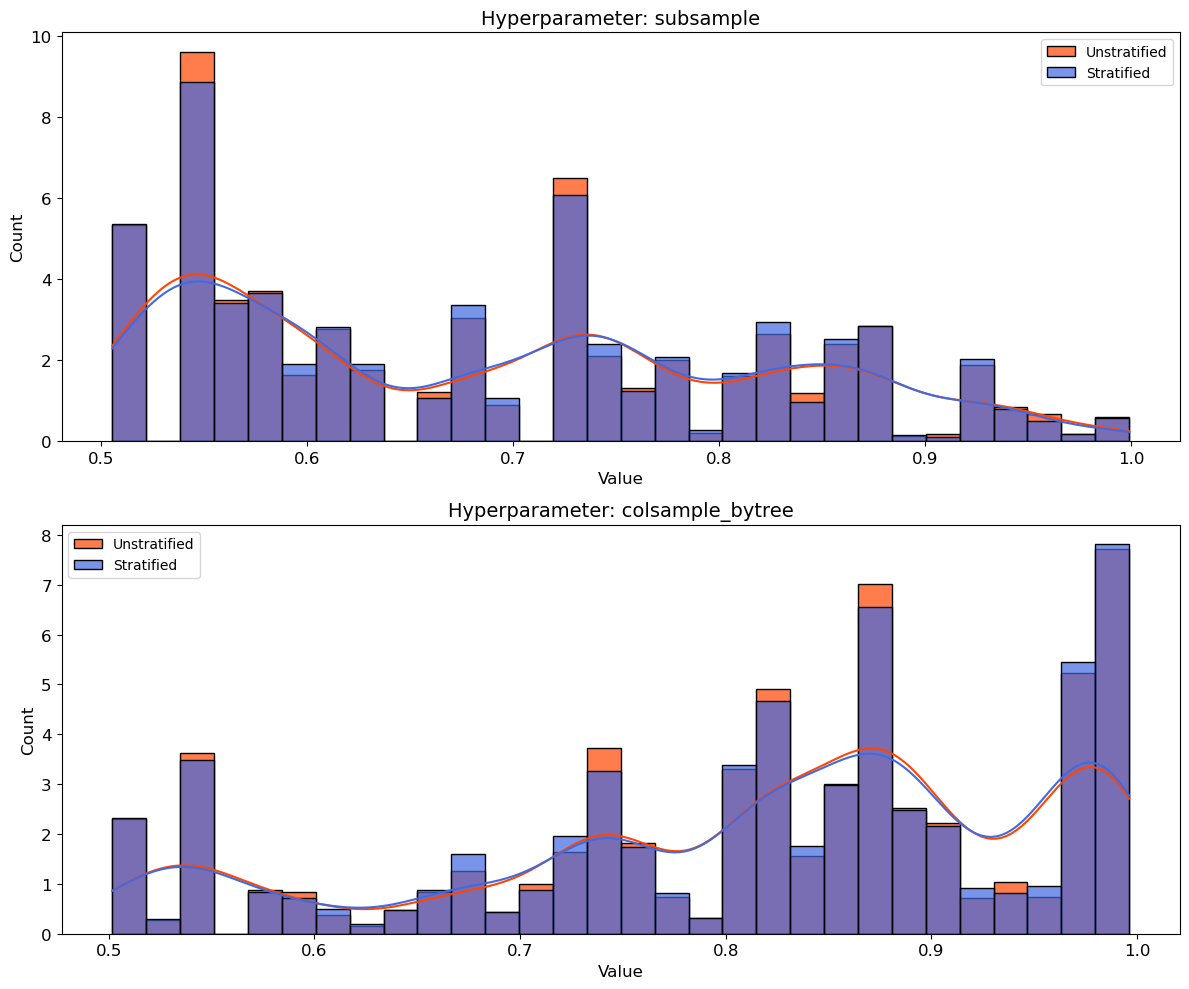

In [20]:
#order = ['max_depth', 'min_child_weight', 'gamma', 'learning_rate']
order = ['subsample', 'colsample_bytree']
plot_hyperparams(data_xgb, order, nrows=2, ncols=1, histo=True)

# Hyperparameter difference per experimental param combo

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# remove waringns
import warnings
warnings.filterwarnings("ignore")

from utils_evaluation import barplot_coloured_by_parameter, barplot_one_var

In [51]:
# set model 
model = 'xgb'

if model == 'rf':
    model_name = 'Random Forest'
elif model == 'xgb':
    model_name = 'XGBoost'
else:
    raise ValueError('model not supported')
    
# load csv
df = pd.read_csv('./tables/' + model +'/results_per_parameter.csv')

df.head()
    

,parameter_combination_string,num_exp,hyperparameter_different,hyperparameter_same,hyperparameter_different_rel,val_train_descriptives_ks_statistic_mean_stratified,val_train_descriptives_ks_statistic_sd_stratified,val_train_descriptives_ks_statistic_mean_unstratified,val_train_descriptives_ks_statistic_sd_unstratified,val_train_descriptives_ks_statistic_mean_diff,...,RandomSearch_Mean_Val_MSE_diff,error_estimator_mean_stratified,error_estimator_sd_stratified,error_estimator_mean_unstratified,error_estimator_sd_unstratified,error_estimator_mean_diff,num_unique_stratified,counts_stratified,num_unique_unstratified,counts_unstratifed
0,xgb_identity_200_5_0,200,159,41,0.795,0.025000,1.739077e-17,0.147800,0.022101,-0.122800,...,-0.096086,-0.140334,8.042785,-0.188377,8.097928,0.048043,[0 1 2 3 4],[68 60 40 26 6],[0 1 2 3 4 5],[74 53 42 21 9 1]
1,xgb_identity_200_5_3,200,179,21,0.895,0.025000,1.739077e-17,0.150912,0.022027,-0.125912,...,-0.290031,-0.091075,17.496514,-0.236090,17.643384,0.145016,[0 1 2 3 4 5 6 7 8 9],[28 11 16 21 20 13 17 14 24 36],[0 1 2 3 4 5 6 7 8 9],[15 9 12 20 16 14 24 26 33 31]
2,xgb_identity_200_10_0,200,156,44,0.780,0.047262,1.654852e-03,0.144875,0.023357,-0.097612,...,-0.114852,-0.134079,8.050743,-0.191505,8.108665,0.057426,[0 1 2 3 4 5 6],[76 54 38 20 8 3 1],[0 1 2 3 4 5 6 7],[69 61 33 19 10 6 1 1]
3,xgb_identity_200_10_3,200,189,11,0.945,0.047194,1.631474e-03,0.149088,0.024588,-0.101894,...,-0.207638,-0.083403,17.468269,-0.187221,17.576848,0.103819,[0 1 2 3 4 5 6 7 8 9],[15 17 14 17 17 23 27 22 19 29],[0 1 2 3 4 5 6 7 8 9],[12 21 21 17 20 20 19 22 25 23]
4,xgb_identity_1000_5_0,200,105,95,0.525,0.005000,3.478153e-18,0.066646,0.010396,-0.061646,...,-0.019310,-0.071075,7.234660,-0.080730,7.244548,0.009655,[0 1 2 3 4],[101 58 29 10 2],[0 1 2 3 4],[97 59 28 13 3]


In [52]:
experimental_parameters = ['param_model', 'param_transformation',  'param_n_train', 'param_group_size', 'param_noise']

# split parameter_combination_string into separate columns
for i, param in enumerate(experimental_parameters):
    df[param] = df['parameter_combination_string'].str.split('_').str[i]

In [53]:
# convert numeric columns to integer type
numeric_columns = ['param_n_train', 'param_group_size', 'param_noise']
df[numeric_columns] = df[numeric_columns].astype(int)

df.head()

print(df.shape)

(24, 39)


In [54]:
# convert numeric columns to integer type
numeric_columns = ['param_n_train', 'param_group_size', 'param_noise']
df[numeric_columns] = df[numeric_columns].astype(int)

df.head()

print(df.shape)

(24, 39)


In [26]:
# count frequency of experimental_parameters
for param in experimental_parameters:
    print(df[param].value_counts())
    print('')

param_model
rf    24
Name: count, dtype: int64

param_transformation
identity    8
log         8
sqrt        8
Name: count, dtype: int64

param_n_train
200     12
1000    12
Name: count, dtype: int64

param_group_size
5     12
10    12
Name: count, dtype: int64

param_noise
0    12
3    12
Name: count, dtype: int64



In [56]:
df['plot'] = df['parameter_combination_string'].str.extract(r'xgb_(.*)')
df.shape

(24, 40)

In [59]:
def barplot_one_var(df, var, title, y_label):
    df_sorted = df.sort_values(by=var)

    if title == 'Random Forest':
        color = 'darkgrey'
    else:
        color = 'grey'

    # Barplot
        
    plt.figure(figsize=(10, 3))  # Adjust figure size as needed
    plt.bar(df_sorted['plot'], df_sorted[var], color= color)
    plt.xlabel('Experimental Parameter Combination', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)

    # Convert x_ticks to list
    #x_ticks = x_ticks.tolist()
    plt.xticks(df_sorted['plot'], rotation=90, fontsize=12)  #
    #plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Boxplot
    plt.figure(figsize=(10, 3))  # Adjust figure size as needed
    sns.boxplot(x=var, data=df_sorted, color='darkgreen')
    plt.xlabel(y_label)
    plt.title(title)
    #plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # stats
    stats = df_sorted[var].describe()
    return stats

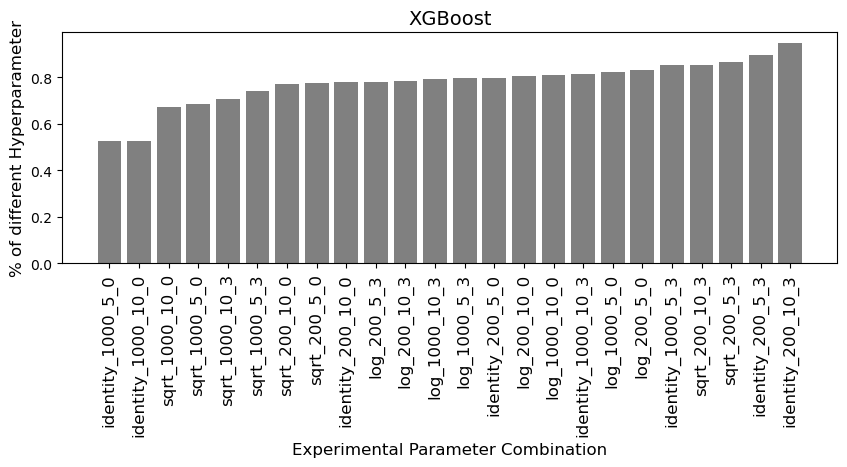

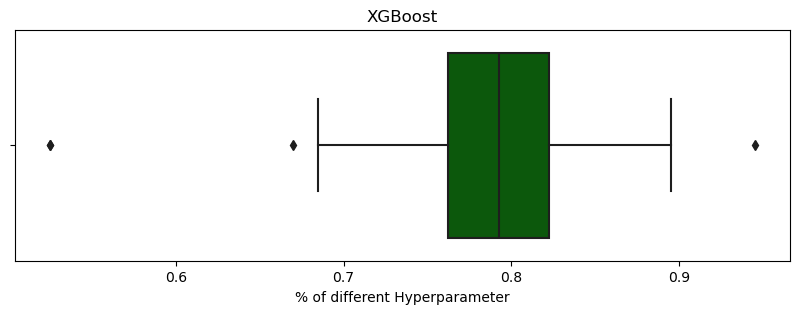

count    24.000000
mean      0.775208
std       0.098439
min       0.525000
25%       0.762500
50%       0.792500
75%       0.822500
max       0.945000
Name: hyperparameter_different_rel, dtype: float64

In [60]:
stats_hyperparameter_different_rel = barplot_one_var(df, 'hyperparameter_different_rel', model_name, "% of different Hyperparameter")
stats_hyperparameter_different_rel

# 3. Plot data generation

In [30]:
from sklearn.datasets import make_friedman1
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
### classes
class FriedmanDataset:
    # Freidman dataset see: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
    def __init__(self, n_samples=1000, n_features=5, noise=0.0, random_state=42):
        self.features, self.y = self.generate_friedman1(n_samples, n_features, noise, random_state)
        self.df = self.to_dataframe(self.features, self.y)

    def generate_friedman1(self, n_samples, n_features, noise, random_state):
        '''
        Function to generate dataset according to Friedman1.
        Inputs:
            n_samples: number of data points
            n_features: number of features (have to be at least 5)
            noise: The standard deviation of the gaussian noise applied to the output.
            random_state: to repreoduce dataset
        Outputs:
            features: array
            y: array

        '''
        features, y = make_friedman1(n_samples=n_samples, 
                                    n_features=n_features, 
                                    noise=noise, 
                                    random_state=random_state)
        return features, y

    def to_dataframe(self, features, y):
        ''' 
        Function to convert arrays to combined dataframe of X and y. (could also add normalization?)
        Inputs: 
            features: first output from generate_friedman1
            y: second output from generate_friedman1
        Output:
            combined dataframe
        '''
        features_df = pd.DataFrame(features, columns=[f'X{i}' for i in range(1, features.shape[1] + 1)])
        y_df = pd.DataFrame(y, columns=['y'])
        return pd.concat([features_df, y_df], axis=1)
    

    def transform(self, transformation='identity', shifting=0):
        '''
        Function to transform the target variable.
        Inputs:
            transformation: the transformation to be applied
        Outputs:
            None (it transforms the target variable of the dataframe and of y itself)
        '''

        if transformation == 'identity':
            pass
        elif transformation == 'log':
            
            shifting = 1.00000001
            self.y = np.log(self.y + shifting)
            self.df['y'] = np.log(self.df['y'].values + shifting)
        elif transformation == 'sqrt':
            self.df['y'] = np.sqrt(self.y+ shifting)
            self.y = np.sqrt(self.df['y'].values + shifting)
        else:
            raise ValueError('Transformation not implemented.')
        
    """
    def transform(self, transformation='log'):
        '''
        Function to transform the target variable.
        Inputs:
            transformation: the transformation to be applied
        Outputs:
            None (it transforms the target variable of the dataframe and of y itself)
        '''
        if transformation == 'identity':
            pass
        elif transformation == 'log':
            self.df['y'] = np.log(self.df['y'])
            self.y = self.df['y'].values  
        elif transformation == 'sqrt':
            self.df['y'] = np.sqrt(self.df['y'])
            self.y = self.df['y'].values  
        else:
            raise ValueError('Transformation not implemented.')
            """


In [31]:
# Data Creation
n_train= 1000
n_train2 = 200
n_test= 100000
n_features = 10
FD_noise= 0
transformation='identity'
seed=567

# Stratification
n_groups = 200

# RandomSearchCV
n_folds = 4
n_iter= 200
n_repetitions= 10
scoring= 'neg_mean_squared_error' 
n_jobs= -1


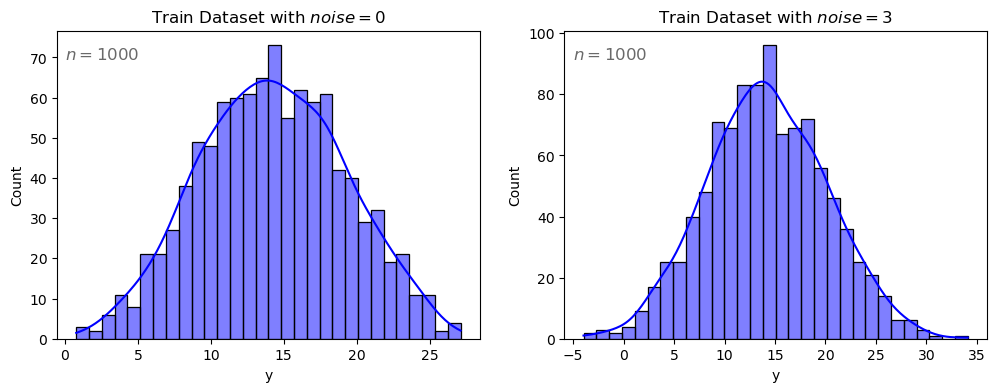

In [32]:
FD_noise2 = 3
transformation='identity'

train2 = FriedmanDataset(n_samples=n_train,
                         n_features=n_features,
                         noise=FD_noise2,
                         random_state=seed)
train2.transform(transformation=transformation)

train = FriedmanDataset(n_samples=n_train, 
                            n_features=n_features, 
                            noise=FD_noise, 
                            random_state=seed)
train.transform(transformation=transformation)


test = FriedmanDataset(n_samples=n_test,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
test.transform(transformation=transformation)


# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset with $noise=0$')
axes[0].text(0.02, 0.95, '$n=1000$', fontsize=12, color='dimgrey', transform=axes[0].transAxes, verticalalignment='top')

#sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
#axes[1].set_title('Test Dataset')
sns.histplot(train2.df, x='y', bins=30, kde=True, ax = axes[1], color='blue')
axes[1].set_title('Train Dataset with $noise=3$')
axes[1].text(0.02, 0.95, '$n=1000$', fontsize=12, color='dimgrey', transform=axes[1].transAxes, verticalalignment='top')
plt.show()

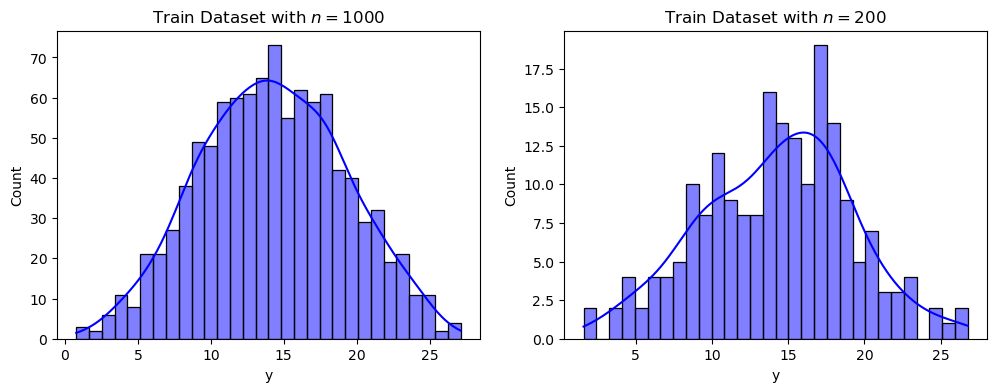

In [33]:
n_train = 1000
FD_noise=0
FD_noise2=0

train = FriedmanDataset(n_samples=n_train, 
                            n_features=n_features, 
                            noise=FD_noise, 
                            random_state=seed)
train.transform(transformation=transformation)


test = FriedmanDataset(n_samples=n_test,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
test.transform(transformation=transformation)

n_train2=200
train2 = FriedmanDataset(n_samples=n_train2,
                         n_features=n_features,
                         noise=FD_noise2,
                         random_state=seed)
train2.transform(transformation=transformation)
# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset with $n=1000$')


#sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
#axes[1].set_title('Test Dataset')
sns.histplot(train2.df, x='y', bins=30, kde=True, ax = axes[1], color='blue')
axes[1].set_title('Train Dataset with $n=200$')

plt.show()

In [34]:

train = FriedmanDataset(n_samples=n_train, 
                            n_features=n_features, 
                            noise=FD_noise, 
                            random_state=seed)
train

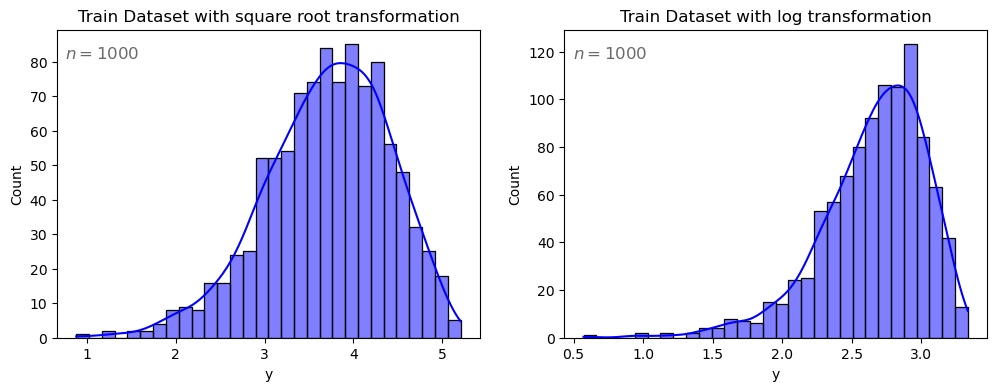

In [35]:
n_train = 1000
n_train2=1000
FD_noise=0
FD_noise2=0
transformation= "sqrt"
transformation2 = "log"

train = FriedmanDataset(n_samples=n_train, 
                            n_features=n_features, 
                            noise=FD_noise, 
                            random_state=seed)
train.transform(transformation=transformation)


test = FriedmanDataset(n_samples=n_test,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
test.transform(transformation=transformation)


train2 = FriedmanDataset(n_samples=n_train2,
                         n_features=n_features,
                         noise=FD_noise2,
                         random_state=seed)
train2.transform(transformation=transformation2)
# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset with square root transformation')
axes[0].text(0.02, 0.95, '$n=1000$', fontsize=12, color='dimgrey', transform=axes[0].transAxes, verticalalignment='top')

#sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
#axes[1].set_title('Test Dataset')

sns.histplot(train2.df, x='y', bins=30, kde=True, ax = axes[1], color='blue')
axes[1].set_title('Train Dataset with log transformation')
axes[1].text(0.02, 0.95, '$n=1000$', fontsize=12, color='dimgrey', transform=axes[1].transAxes, verticalalignment='top')
plt.show()


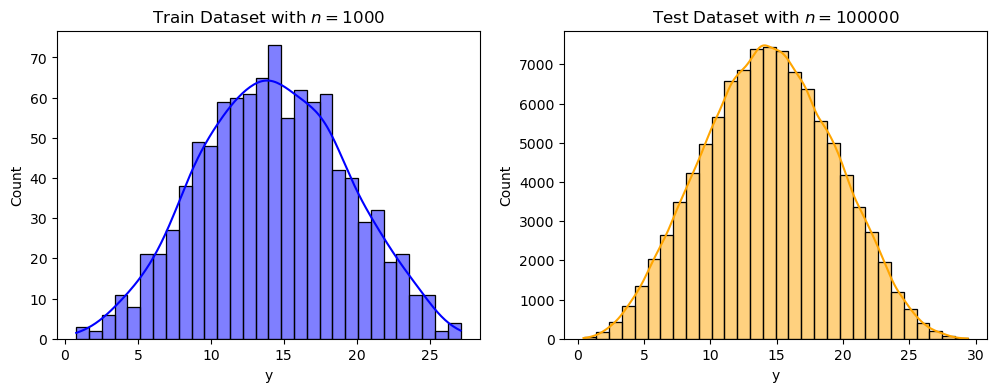

In [36]:
n_train = 1000
n_train2=1000
FD_noise=0
FD_noise2=0
transformation= "identity"


train = FriedmanDataset(n_samples=n_train, 
                            n_features=n_features, 
                            noise=FD_noise, 
                            random_state=seed)
train.transform(transformation=transformation)


test = FriedmanDataset(n_samples=n_test,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
test.transform(transformation=transformation)


# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset with $n=1000$')


sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Test Dataset with $n=100000$')

plt.show()


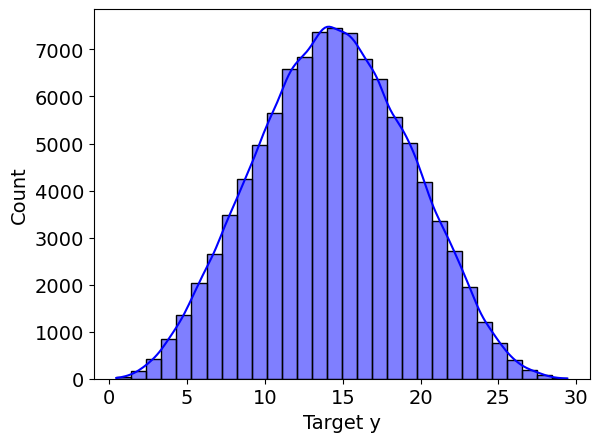

In [37]:
test = FriedmanDataset(n_samples=n_test,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
test.transform(transformation=transformation)

plt.figsize=(8,6)
sns.histplot(test.df, x='y', bins=30, kde=True, color='blue')
#plt.title('Test Dataset with $n=100000$', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)	
plt.xlabel('Target y', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

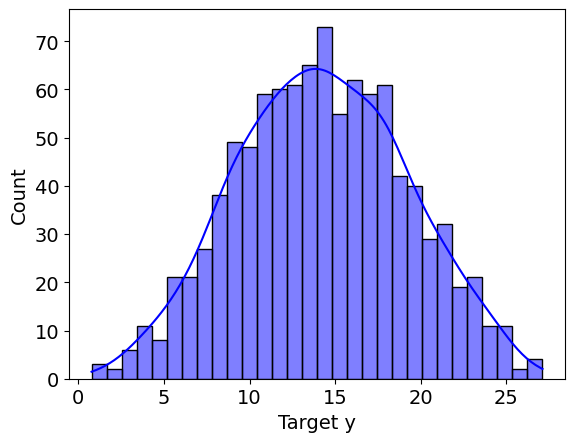

In [38]:
n_train = 1000
FD_noise=0

train = FriedmanDataset(n_samples=n_train,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
train.transform(transformation=transformation)

plt.figsize=(8,6)
sns.histplot(train.df, x='y', bins=30, kde=True, color='blue')
# plt.title('Train Dataset with $n=1000$', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)	
plt.xlabel('Target y', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

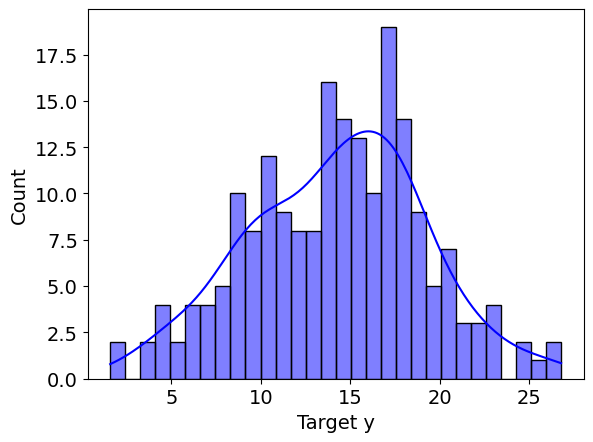

In [39]:
n_train = 200
FD_noise=0

train = FriedmanDataset(n_samples=n_train,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
train.transform(transformation=transformation)

plt.figsize=(8,6)
sns.histplot(train.df, x='y', bins=30, kde=True, color='blue')
#plt.title('Train Dataset with $n=1000$', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)	
plt.xlabel('Target y', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

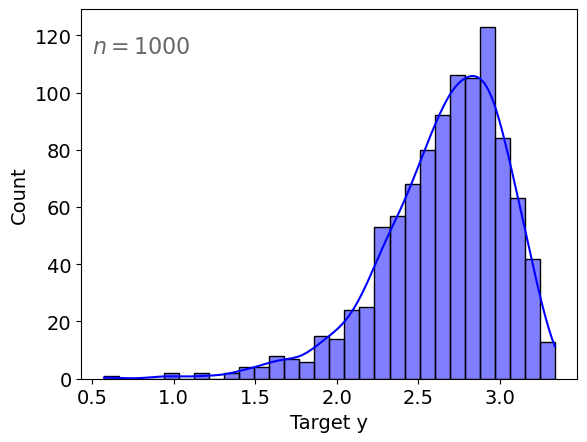

In [40]:
n_train = 1000
FD_noise=0
transformation = "log"

train = FriedmanDataset(n_samples=n_train,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
train.transform(transformation=transformation)

plt.figsize=(8,6)
sns.histplot(train.df, x='y', bins=30, kde=True, color='blue')
#plt.title('Train Dataset with $n=1000$', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)	
plt.xlabel('Target y', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.text(0.5, 120, '$n=1000$', fontsize=16, color='dimgrey', verticalalignment='top')
plt.show()

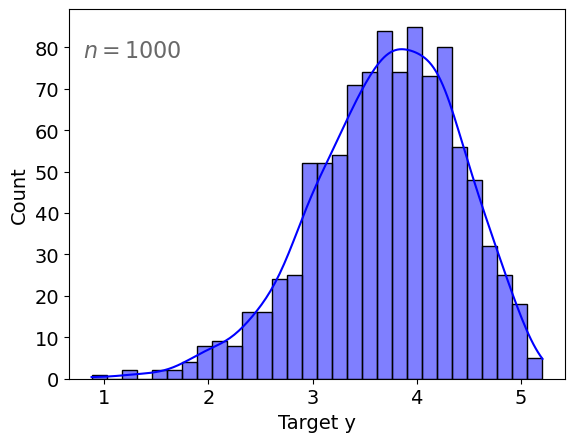

In [41]:
n_train = 1000
FD_noise=0
transformation = "sqrt"

train = FriedmanDataset(n_samples=n_train,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
train.transform(transformation=transformation)

plt.figsize=(8,6)
sns.histplot(train.df, x='y', bins=30, kde=True, color='blue')
#plt.title('Train Dataset with $n=1000$', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)	
plt.xlabel('Target y', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.text(0.8, 82, '$n=1000$', fontsize=16, color='dimgrey', verticalalignment='top')
plt.show()

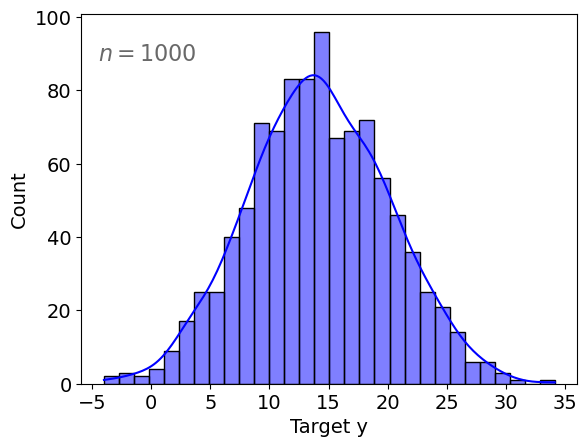

In [42]:
n_train = 1000
FD_noise=3

transformation = "identity"

train = FriedmanDataset(n_samples=n_train,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
train.transform(transformation=transformation)

plt.figsize=(8,6)
sns.histplot(train.df, x='y', bins=30, kde=True, color='blue')
#plt.title('Train Dataset with $n=1000$', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)	
plt.xlabel('Target y', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.text(-4.5, 93, '$n=1000$', fontsize=16, color='dimgrey', verticalalignment='top')
plt.show()